# SNACK: Sequence Normalized Alignment Comparison Kit

This notebook demonstrates the use of the SNACK library for protein sequence alignment and compares its performance against traditional methods like PAM and BLOSUM.

## 1. Setup and Imports

Import necessary libraries and configure the environment.

In [15]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Align import substitution_matrices

from snack.features import FeatureSpace
from snack.metric import Snack
from snack.alignment import needleman_wunsch
from snack.data import load_msf_data
from snack.train import train_model, get_device

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Load Data and Train SNACK Model

Load sequence alignment data and train the SNACK model. For demonstration, we'll use a small subset of the BALIBASE dataset and a few training epochs.

In [16]:
# Get the current directory and use relative path for dataset
dataset_path = "../data"

# Auto-detect the best available device
device = get_device()

# Инициализируем пространство признаков
feature_space = FeatureSpace()

# Инициализируем модель с метрикой
snack = Snack(feature_space=feature_space)

# Запускаем обучение с использованием GPU/MPS если доступно
train_model(
    model=snack,
    dataset_path=dataset_path,
    num_epochs=10,
    learning_rate=0.001,
    batch_size=32,
    device=device,
)


Training on device: mps


 77%|███████▋  | 10/13 [01:38<00:37, 12.56s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7072.2617


100%|██████████| 13/13 [03:27<00:00, 15.97s/it]


Epoch [1/10], Loss: 8995.6306, Time: 207.62s, LR: 0.001000
New best loss: 8995.6306


 77%|███████▋  | 10/13 [01:36<00:38, 12.80s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7066.8434


100%|██████████| 13/13 [03:24<00:00, 15.72s/it]


Epoch [2/10], Loss: 8986.4826, Time: 204.35s, LR: 0.001000
New best loss: 8986.4826


 77%|███████▋  | 10/13 [01:35<00:37, 12.42s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7061.6716


100%|██████████| 13/13 [03:25<00:00, 15.78s/it]


Epoch [3/10], Loss: 8977.1870, Time: 205.13s, LR: 0.001000
New best loss: 8977.1870


 77%|███████▋  | 10/13 [01:42<00:42, 14.21s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7049.8947


100%|██████████| 13/13 [03:30<00:00, 16.20s/it]


Epoch [4/10], Loss: 8962.2447, Time: 210.57s, LR: 0.001000
New best loss: 8962.2447


 77%|███████▋  | 10/13 [01:40<00:39, 13.12s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7043.3585


100%|██████████| 13/13 [03:31<00:00, 16.24s/it]


Epoch [5/10], Loss: 8953.3936, Time: 211.19s, LR: 0.001000
New best loss: 8953.3936


 77%|███████▋  | 10/13 [01:35<00:38, 12.76s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7053.0223


100%|██████████| 13/13 [03:24<00:00, 15.75s/it]


Epoch [6/10], Loss: 8962.2602, Time: 204.73s, LR: 0.001000


 77%|███████▋  | 10/13 [01:35<00:37, 12.55s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7052.0153


100%|██████████| 13/13 [03:26<00:00, 15.87s/it]


Epoch [7/10], Loss: 8955.4478, Time: 206.30s, LR: 0.001000


 77%|███████▋  | 10/13 [01:39<00:38, 12.98s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7047.7667


100%|██████████| 13/13 [03:27<00:00, 15.99s/it]


Epoch [8/10], Loss: 8947.3662, Time: 207.90s, LR: 0.001000
New best loss: 8947.3662


 77%|███████▋  | 10/13 [01:34<00:37, 12.36s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7042.1565


100%|██████████| 13/13 [03:23<00:00, 15.63s/it]


Epoch [9/10], Loss: 8935.8318, Time: 203.18s, LR: 0.001000
New best loss: 8935.8318


 77%|███████▋  | 10/13 [01:34<00:37, 12.44s/it]

  Batch 10, Progress: 320/386 pairs, Loss: 7037.1086


100%|██████████| 13/13 [03:18<00:00, 15.30s/it]

Epoch [10/10], Loss: 8925.4992, Time: 198.93s, LR: 0.001000
New best loss: 8925.4992
Training completed in 2059.89s


## 3. Load PAM and BLOSUM Matrices

Load standard PAM250 and BLOSUM62 substitution matrices from BioPython.

In [17]:
pam250 = substitution_matrices.load('PAM250')
blosum62 = substitution_matrices.load('BLOSUM62')

print("PAM250 and BLOSUM62 matrices loaded.")

PAM250 and BLOSUM62 matrices loaded.


## 4. Define Alignment and Scoring Functions

Define functions to perform sequence alignment using Needleman-Wunsch and calculate alignment scores for each method.

In [18]:
def pam_scorer(char1, char2):
    """Returns the cost for aligning char1 and char2 using PAM250.
    Gaps incur a positive_gap_cost.
    Matches/mismatches are negative of the PAM250 score (lower cost is better)."""
    # Negate the score to make it a cost
    return -pam250.get((char1, char2), pam250.get((char2, char1), 0))

def blosum_scorer(char1, char2):
    """Returns the cost for aligning char1 and char2 using BLOSUM62.
    Gaps incur a positive_gap_cost.
    Matches/mismatches are negative of the BLOSUM62 score (lower cost is better)."""
    # Negate the score to make it a cost
    return -blosum62.get((char1, char2), blosum62.get((char2, char1), 0))

print("Alignment and scoring functions defined.")

Alignment and scoring functions defined.


## 5. Perform Alignments and Compare Scores

Select a pair of sequences and align them using SNACK, PAM250, and BLOSUM62. Then, compare their alignment scores.

In [19]:
# Load a few example sequences from the dataset for comparison
# This requires your load_msf_data to be robust or pick specific files
try:
    alignment_data_full = load_msf_data(dataset_path)
    # Take the first pair of sequences from the first file for a simple demo
    if alignment_data_full:
        seq1_example, seq2_example = alignment_data_full[0][0], alignment_data_full[0][1]
        # No truncation - using full sequences
        print(f"Using example sequences:\nSeq1: {seq1_example[:50]}... (full length: {len(seq1_example)})\nSeq2: {seq2_example[:50]}... (full length: {len(seq2_example)})")
    else:
        print("No data loaded, using dummy sequences.")
        seq1_example, seq2_example = "GARFIELDTHECAT", "GARFIELDTHEBIGCAT"
except Exception as e:
    print(f"Error loading data: {e}. Using dummy sequences.")
    seq1_example, seq2_example = "PLEASANTLY", "MEANLY"

# Align using SNACK (Needleman-Wunsch from snack.alignment using the SNACK metric as cost)
print("\nAligning with SNACK...")
aligned_snack1, aligned_snack2 = needleman_wunsch(seq1_example, seq2_example, snack)
score_snack_cost = 0
for s_a, s_b in zip(aligned_snack1, aligned_snack2):
    score_snack_cost += snack(s_a, s_b) # Assumes snack handles gaps appropriately

print("--- SNACK Alignment ---")
print(aligned_snack1)
print(aligned_snack2)
print(f"SNACK alignment cost (lower is better): {score_snack_cost}")

# Align using PAM250 with the package's needleman_wunsch and cost-based pam_scorer
print("\nAligning with PAM250 (cost-based)...")
aligned_pam1, aligned_pam2 = needleman_wunsch(seq1_example, seq2_example, pam_scorer)
score_pam_cost = 0
for s_a, s_b in zip(aligned_pam1, aligned_pam2):
    score_pam_cost += pam_scorer(s_a, s_b)

print("--- PAM250 Alignment ---")
print(aligned_pam1)
print(aligned_pam2)
print(f"PAM250 alignment cost (lower is better): {score_pam_cost}")

# Align using BLOSUM62 with the package's needleman_wunsch and cost-based blosum_scorer
print("\nAligning with BLOSUM62 (cost-based)...")
aligned_blosum1, aligned_blosum2 = needleman_wunsch(seq1_example, seq2_example, blosum_scorer)
score_blosum_cost = 0
for s_a, s_b in zip(aligned_blosum1, aligned_blosum2):
    score_blosum_cost += blosum_scorer(s_a, s_b)

print("--- BLOSUM62 Alignment ---")
print(aligned_blosum1)
print(aligned_blosum2)
print(f"BLOSUM62 alignment cost (lower is better): {score_blosum_cost}")

Using example sequences:
Seq1: --------------------------------------------------... (full length: 895)
Seq2: --------------------------------------------------... (full length: 895)

Aligning with SNACK...
--- SNACK Alignment ---
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------PKIVILPHQDLCPDGAVLEANSGETILDAALRNGIEIE-HACEKSCACTTCHCIVREGFDSL----PESSEQ-EDDMLDKAWG-LEPESRLSCQARVT---DEDLVVEIPRYTINHARE------------------------------------------------------------------------------------------------------------------------------------

## 6. Visualize Substitution Matrices

Visualize the SNACK learned substitution matrix (if applicable and interpretable as such) alongside PAM250 and BLOSUM62.

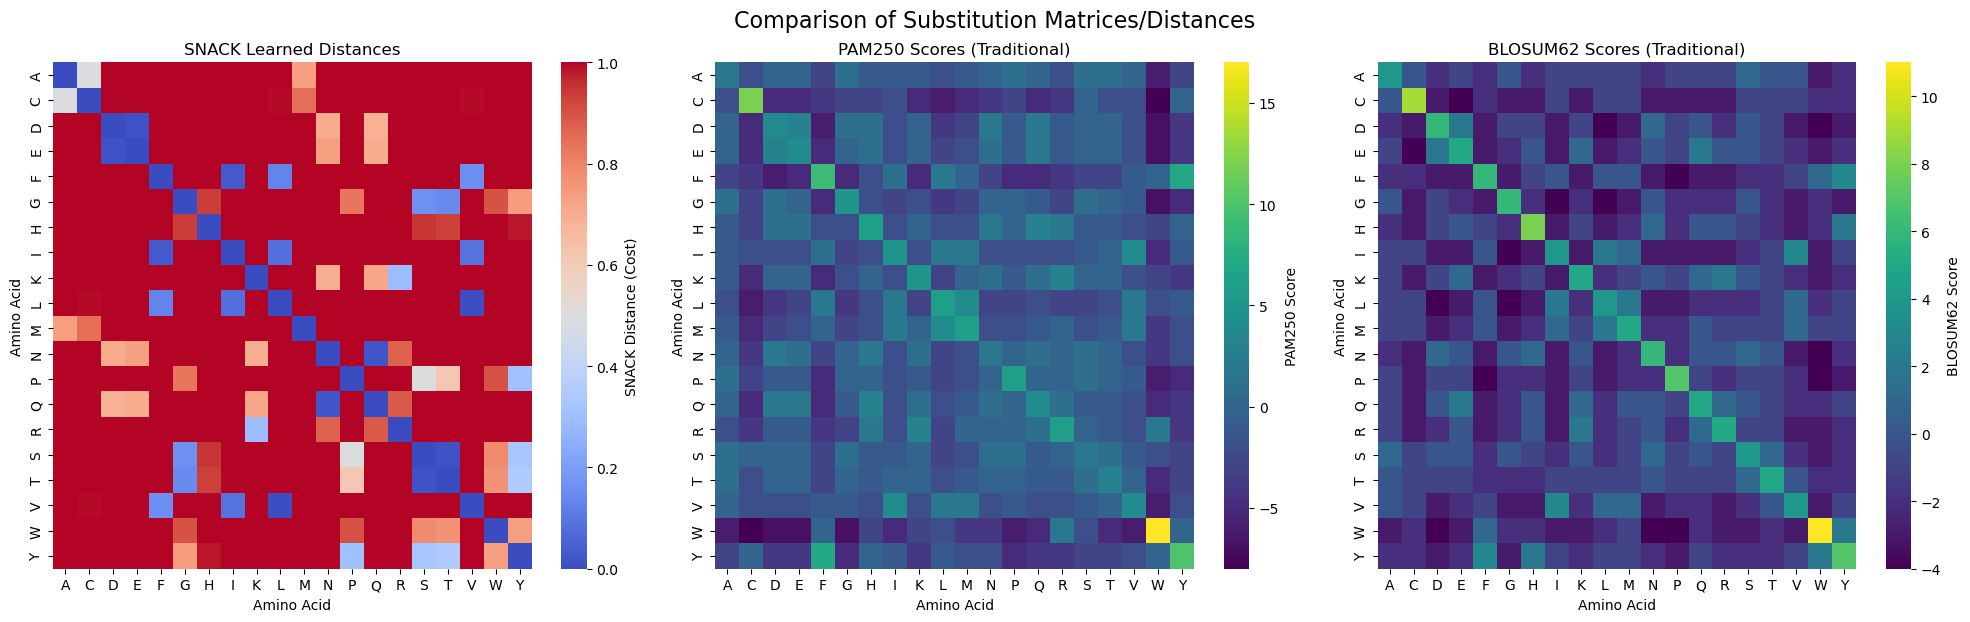

In [20]:
amino_acids = sorted(list(set(seq1_example + seq2_example) - set('-')))
if not amino_acids: # Fallback if sequences were empty or only gaps
    amino_acids = list('ACDEFGHIKLMNPQRSTVWY')

# SNACK's M matrix (or a transformation of it) can be visualized.
# The M matrix is in the feature space. To get an AA-to-AA matrix, we'd compute d(aa1, aa2) for all pairs.
snack_viz_matrix = np.zeros((len(amino_acids), len(amino_acids)))
for i, aa1 in enumerate(amino_acids):
    for j, aa2 in enumerate(amino_acids):
        # SNACK metric returns a distance. For visualization as a substitution matrix,
        # one might want similarity (e.g., max_dist - dist, or 1/dist if dist > 0).
        # This depends on how SNACK's distances are scaled and interpreted.
        # Let's just show the raw distances for now.
        snack_viz_matrix[i, j] = snack(aa1, aa2).item() # .item() if it's a tensor

# Now PAM and BLOSUM are also costs (negative of traditional scores)
pam250_cost_matrix = np.array([[pam_scorer(aa1, aa2) for aa2 in amino_acids] for aa1 in amino_acids])
blosum62_cost_matrix = np.array([[blosum_scorer(aa1, aa2) for aa2 in amino_acids] for aa1 in amino_acids])

# Convert back to traditional scores for visualization to maintain consistency
pam250_score_matrix = -pam250_cost_matrix
blosum62_score_matrix = -blosum62_cost_matrix

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(snack_viz_matrix, ax=axes[0], cmap="coolwarm", annot=False, 
            xticklabels=amino_acids, yticklabels=amino_acids, cbar_kws={'label': 'SNACK Distance (Cost)'})
axes[0].set_title("SNACK Learned Distances")
axes[0].set_xlabel("Amino Acid")
axes[0].set_ylabel("Amino Acid")

sns.heatmap(pam250_score_matrix, ax=axes[1], cmap="viridis", annot=False, 
            xticklabels=amino_acids, yticklabels=amino_acids, cbar_kws={'label': 'PAM250 Score'})
axes[1].set_title("PAM250 Scores (Traditional)")
axes[1].set_xlabel("Amino Acid")
axes[1].set_ylabel("Amino Acid")

sns.heatmap(blosum62_score_matrix, ax=axes[2], cmap="viridis", annot=False, 
            xticklabels=amino_acids, yticklabels=amino_acids, cbar_kws={'label': 'BLOSUM62 Score'})
axes[2].set_title("BLOSUM62 Scores (Traditional)")
axes[2].set_xlabel("Amino Acid")
axes[2].set_ylabel("Amino Acid")

plt.tight_layout()
plt.suptitle("Comparison of Substitution Matrices/Distances", fontsize=16, y=1.03)
plt.show()

## 7. Further Analysis and Discussion

- **Quantitative Comparison**: To rigorously compare SNACK with PAM/BLOSUM, one could use benchmark datasets (e.g., BAliBASE) and evaluate alignment quality using metrics like Sum-of-Pairs Score (SPS) or Total Column Score (TCS) against reference alignments.
- **SNACK Score Interpretation**: The raw cost from SNACK's Needleman-Wunsch needs a clear interpretation or transformation to be directly comparable to PAM/BLOSUM scores. If SNACK aims to produce biologically meaningful alignments, its scoring should correlate with known evolutionary or structural similarities.
- **Gap Handling**: The current notebook uses a simple linear gap penalty. Affine gap penalties are more common and could be implemented for a more robust comparison.
- **Statistical Significance**: Differences in alignment scores or quality metrics should be tested for statistical significance.

## 8. Conclusion

This notebook provided a basic framework for training a SNACK model, performing alignments, and comparing its behavior to PAM and BLOSUM matrices. Further development and rigorous benchmarking are needed to fully assess the capabilities of the SNACK methodology.